In [13]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import os
from IPython.display import clear_output
import random
import matplotlib.pyplot as plt
import pickle
import time
import pandas as pd

In [14]:
rng = np.random.default_rng()

In [15]:
class RewardGraphic():
    def __init__(self, window_size=1000):
        self.window_size = window_size

    def Graphic_reward_per_episode(self, rewards_per_episode, episodes, epsilons):
        plt.figure(figsize=(10, 6))  # Tamaño de la figura
        
        for i, epsilon in enumerate(epsilons):
            sum_rewards = np.zeros(episodes)
            for t in range(episodes):
                sum_rewards[t] = np.sum(rewards_per_episode[epsilon][max(0, t-self.window_size):(t+1)])

            print(f"Final average reward for epsilon={epsilon}:", np.mean(sum_rewards[-1000:]))
            plt.plot(sum_rewards, label=f'$\epsilon$ = {epsilon}')

        plt.xlabel('Episodes')
        plt.ylabel('Suma de recompensas')
        plt.title('Suma de recompensas a lo largo del tiempo')
        plt.legend()
        plt.grid(True)
        plt.savefig(f'CliffWalking_combined.png')
        plt.show()
        
    def Graphic_reward_per_epsilon(self, reward_per_epsilon, epsilons):
        plt.figure(figsize=(8, 5))
        for epsilon in epsilons:
            plt.plot(reward_per_epsilon[epsilon], label=f'$\epsilon$ = {epsilon}')
        plt.legend()
        plt.grid(True)
        plt.xlabel('Episodios')
        plt.ylabel('Recompensa media')
        plt.title('Recompensa media por episodio para diferentes valores de $\epsilon$')
        plt.show()

<>:14: SyntaxWarning: invalid escape sequence '\e'
<>:27: SyntaxWarning: invalid escape sequence '\e'
<>:32: SyntaxWarning: invalid escape sequence '\e'
<>:14: SyntaxWarning: invalid escape sequence '\e'
<>:27: SyntaxWarning: invalid escape sequence '\e'
<>:32: SyntaxWarning: invalid escape sequence '\e'
C:\Users\ANIMETX\AppData\Local\Temp\ipykernel_20432\1449826397.py:14: SyntaxWarning: invalid escape sequence '\e'
  plt.plot(sum_rewards, label=f'$\epsilon$ = {epsilon}')
C:\Users\ANIMETX\AppData\Local\Temp\ipykernel_20432\1449826397.py:27: SyntaxWarning: invalid escape sequence '\e'
  plt.plot(reward_per_epsilon[epsilon], label=f'$\epsilon$ = {epsilon}')
C:\Users\ANIMETX\AppData\Local\Temp\ipykernel_20432\1449826397.py:32: SyntaxWarning: invalid escape sequence '\e'
  plt.title('Recompensa media por episodio para diferentes valores de $\epsilon$')


In [16]:
class Game():
    def __init__(self, Agent, explore=True):
        self.agent = Agent
        self.explore = explore
        self.is_explore()

    def is_explore(self):
        if self.explore:
            self.agent.q = np.zeros((self.agent.env.observation_space.n, self.agent.env.action_space.n))
        else:
            self.agent.load_pickle()
            
    def run(self, episodes=100):
        RENDER_AT_EPISODE = 1
        rewards_per_episode = np.zeros(episodes)
        
        for episode in range(episodes):
            state = self.agent.reset()
            episode_reward = 0
            terminated = False
            truncated = False
            done = False

            while not terminated and not truncated:
                
                action = self.agent.choose_action(state, self.explore)
                next_state, reward, terminated, truncated, _ = self.agent.env.step(action)
                done = terminated or truncated
                
                if self.explore:
                    self.agent.learn(state, action, reward, next_state, done)
                
                state = next_state
                episode_reward += reward
            
            if episode % RENDER_AT_EPISODE == 0:
                clear_output(wait=True)
                self.agent.env.render()
            # self.agent.epsilon = max(self.agent.epsilon - self.agent.epsilon_decay_rate, 0.01)
            rewards_per_episode[episode] = episode_reward
            print(f"Episode {episode}/{episodes}, Epsilon: {self.agent.epsilon:.4f}, Reward: {episode_reward:.4f}")
        self.agent.save_pickle()
        self.agent.env.close()
        return rewards_per_episode

In [17]:
class Agent():
    def __init__(self,env ,epsilon, alpha=0.01, gamma=0.99):
        #hiperparametros
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        #variables
        self.url_pickle = f"CliffWalking{self.epsilon}.pkl"
        self.episode_reward = 0
        self.env = env
        self.q = np.zeros((env.observation_space.n, env.action_space.n))
        self.action_counts = np.zeros((env.observation_space.n, env.action_space.n))
    
    def reset(self):
        return self.env.reset()[0]
    
    def select_best_action(self, explore, state):
        max_q = np.max(self.q[state, :])
        actions = np.where(self.q[state, :] == max_q)[0]
        return np.random.choice(actions)

    def choose_action(self, state, explore):
        if explore and np.random.uniform(0, 1) < self.epsilon:
            return self.env.action_space.sample()
        else:
            return self.select_best_action(explore, state)

    def learn(self, state, action, reward, next_state, done):
        best_next_action = np.argmax(self.q[next_state])
        td_target = reward + self.gamma * self.q[next_state, best_next_action] * (not done)
        self.q[state, action] += self.alpha * (td_target - self.q[state, action])
        self.action_counts[state, action] += 1

    def save_pickle(self):
            with open(self.url_pickle, "wb") as f:
                pickle.dump(self.q, f)

    def load_pickle(self):
        print("Loading pickle")
        with open(self.url_pickle, 'rb') as f:
            self.q = pickle.load(f)
            self.action_counts = np.zeros(self.env.action_space.n)

In [18]:
epsilons = [1, 0]
reward_per_epsilon = {}
reward_per_episode = {}
games = {}
graphic = RewardGraphic()
render = False
env = gym.make('CliffWalking-v0', render_mode="human" if render else None)

for epsilon in epsilons:
    agent = Agent(env ,epsilon)
    game = Game(agent, explore=True)
    games[epsilon] = game

for epsilon, game in games.items():
    episodes = 100
    reward_per_episode[epsilon] = game.run(episodes)
    reward_per_epsilon[epsilon] =  reward_per_episode[epsilon]/ episodes

Episode 99/100, Epsilon: 0.0000, Reward: -14659.0000


Final average reward for epsilon=1: -3359807.7
Final average reward for epsilon=0: -952456.9


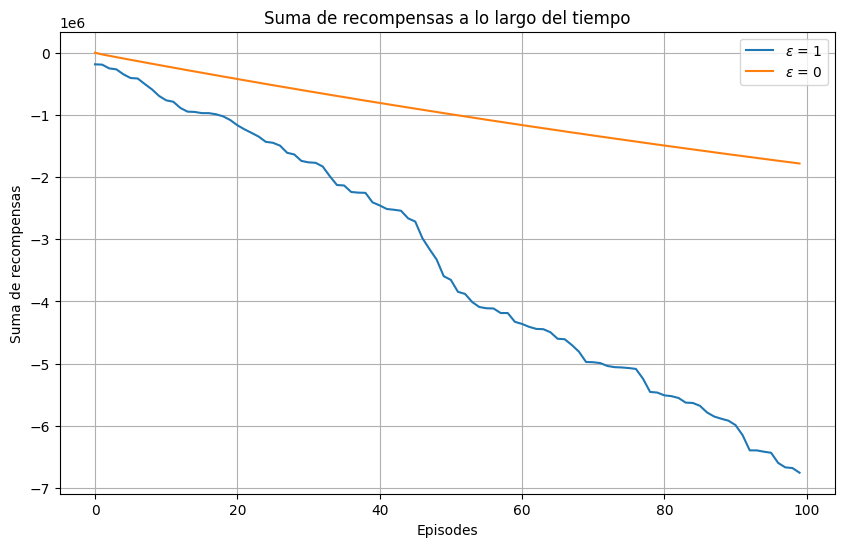

In [19]:
graphic.Graphic_reward_per_episode(reward_per_episode, episodes, epsilons)

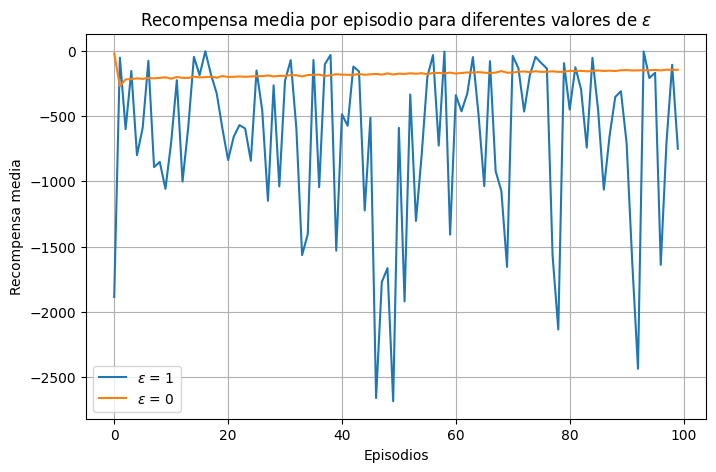

In [20]:
graphic.Graphic_reward_per_epsilon(reward_per_epsilon, epsilons)

In [21]:
render = True
explore = False
epsilon = 0
env = gym.make('CliffWalking-v0', render_mode="human" if render else None)
agent = Agent(env, epsilon)
game = Game(agent, explore=explore)
game.run(2)

Loading pickle
Optimistic initial values


KeyboardInterrupt: 

0: Move up

1: Move right

2: Move down

3: Move left

In [56]:
q_df = pd.DataFrame(games[0].agent.q)
print("Q-table as DataFrame:")
q_df

Q-table as DataFrame:


,0,1,2,3
0,367.417408,367.420765,367.382975,367.417408
1,367.604422,367.585643,367.588537,367.560286
2,367.838294,367.846173,367.808669,367.817747
3,368.072284,368.058567,368.092197,368.087166
4,368.306390,368.305639,368.296323,368.316972
5,368.540613,368.499005,368.517154,368.508903
6,368.681204,368.655268,368.685004,368.700135
7,368.821836,368.831114,368.795571,368.815136
8,368.962511,368.941455,368.932521,368.928297
9,369.009412,369.028532,368.999111,369.027911


: 